In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
vol_file = Path('../Voltron_data/Voltron_Log_DRN_Exp.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
# using Path to handle switches filesystems
if platform == "linux" or platform == "linux2":
    dir_folder = Path('/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/')
elif platform == 'win32':
    dir_folder = Path('U:\\Takashi') # put folder for windows system
include_inds = np.array([4, 5, 11, 12, 13, 14, 22, 31, 32, 33, 34, 38, 39, 43, 52, 54])

sigma=20;
short_kernel=(1/(np.sqrt(2*np.pi)*sigma))*np.exp(-(np.arange(-60,61)**2)/(2*sigma**2))

In [5]:
from scipy.signal import medfilt
row = dat_xls_file.iloc[include_inds[0]]
folder = row['folder']
fish = row['fish']
dat_dir = dir_folder/f'{folder}/{fish}/Data/'
swim_dir = dir_folder/f'{folder}/{fish}/swim/'
dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
dff = dff - np.median(dff, axis=1, keepdims=True)
spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')
time_dff = dff.shape[1] - spk.shape[1]

In [105]:
subvolt = dff.copy()
for n, ndff in enumerate(dff):
    subvolt[n, :] = medfilt(ndff, kernel_size=51)

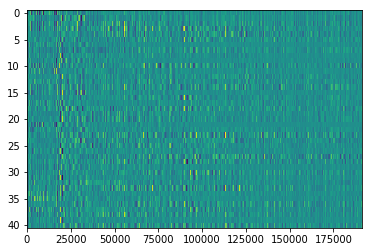

In [9]:
plt.imshow(subvolt/np.abs(subvolt).max(axis=1, keepdims=True), aspect='auto')
plt.show()

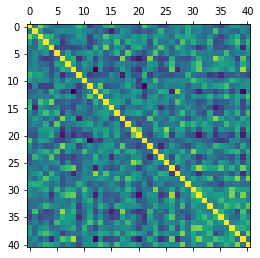

In [13]:
plt.matshow(np.corrcoef(subvolt))
plt.show()

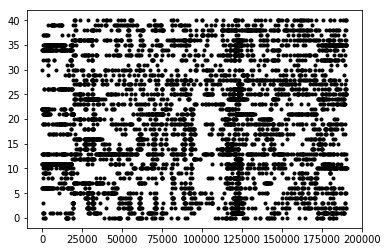

In [26]:
for n, nspk in enumerate(spk):
    tspk = np.where(nspk)[0]
    plt.plot(tspk, np.ones(len(tspk))*n, '.k')
plt.show()

In [86]:
from scipy.ndimage.filters import gaussian_filter1d
gauss_rate = gaussian_filter1d(spk, 0.5*300, mode='nearest')
gauss_init = gauss_rate[:, :300].mean(axis=1, keepdims=True)
gauss_init = np.repeat(gauss_init, 600, axis=1)
gauss_rate = np.hstack([gauss_init, gauss_rate])

## Dimensionality reduction on spike or subthreshold

In [50]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(subvolt.T)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

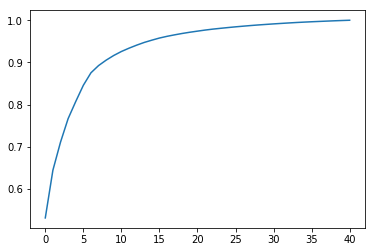

In [51]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [54]:
np.where(np.cumsum(pca.explained_variance_ratio_)>0.95)[0][0]

14

In [56]:
Xnew = pca.fit_transform(subvolt.T)

In [58]:
Xnew.shape

(191200, 41)

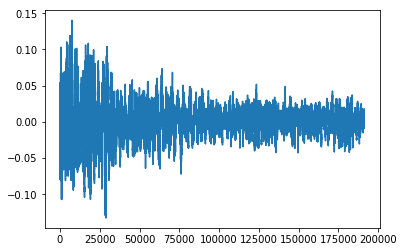

In [64]:
plt.plot(Xnew[:, 3])

## Spike during swim and memory delay

In [67]:
swim_starts = np.where(np.diff((frame_swim_tcourse[0,:]>0).astype('int'))==1)[0]
swim_ends   = np.where(np.diff((frame_swim_tcourse[0,:]>0).astype('int'))==-1)[0]
valid_swim  = (swim_starts>50) & (swim_starts<(frame_swim_tcourse.shape[1]-250))

In [69]:
swim_ends   = swim_ends[valid_swim]
swim_starts = swim_starts[valid_swim]

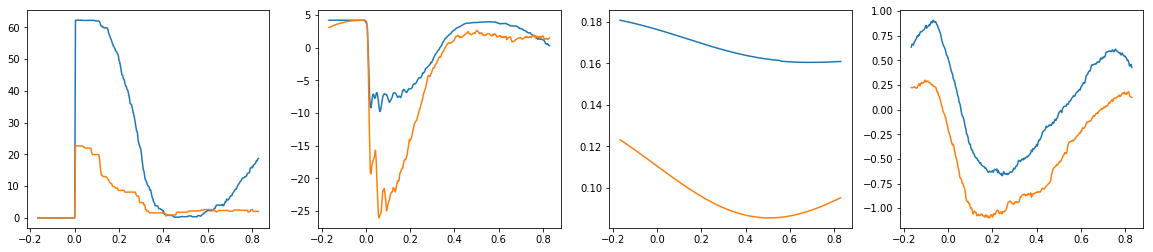

In [92]:
## swim count in each task period
task_period = frame_stimParams[2,swim_starts]
task_index   = frame_stimParams[2,:]+(frame_stimParams[3,:]-1)*4+(frame_stimParams[4,:]-1)*12;
swim_task_index =  task_index[swim_starts]
swim_count  = np.zeros((len(swim_starts),))
ind_old=0
for s in range(len(swim_starts)):
    ind=swim_task_index[s]
    if (ind>ind_old):
        swim_count[s]=1
        ind_old=ind
    elif (ind==ind_old):
        swim_count[s]=swim_count[s-1]+1
        
## mean swim ptterns\
ncell = 0
ave_swim=np.zeros((len(swim_starts),300))
ave_visu=np.zeros((len(swim_starts),300))
ave_resp_spk=np.zeros((len(swim_starts),300));
ave_resp_subvolt=np.zeros((len(swim_starts),300));
for i in range(len(swim_starts)):
    ave_swim[i,:]=frame_swim_tcourse[2,(swim_starts[i]-50):(swim_starts[i]+250)]*100000
    ave_visu[i,:]=-frame_stimParams[0,(swim_starts[i]-50):(swim_starts[i]+250)]*10000
    ave_resp_spk[i,:]=gauss_rate[ncell,(swim_starts[i]-50):(swim_starts[i]+250)]*300
    ave_resp_subvolt[i,:]= subvolt[ncell,(swim_starts[i]-50):(swim_starts[i]+250)]*100
plt.figure(figsize=(20, 4))
plt.subplot(1,4,1)
plt.plot(np.arange(-50,250)/300,ave_swim[task_period==1,:].mean(axis=0))
plt.plot(np.arange(-50,250)/300,ave_swim[task_period==2,:].mean(axis=0))
plt.subplot(1,4,2)
plt.plot(np.arange(-50,250)/300,ave_visu[task_period==1,:].mean(axis=0))
plt.plot(np.arange(-50,250)/300,ave_visu[task_period==2,:].mean(axis=0))
plt.subplot(1,4,3)
plt.plot(np.arange(-50,250)/300,ave_resp_spk[task_period==1,:].mean(axis=0))
plt.plot(np.arange(-50,250)/300,ave_resp_spk[task_period==2,:].mean(axis=0))
plt.subplot(1,4,4)
plt.plot(np.arange(-50,250)/300,ave_resp_subvolt[task_period==1,:].mean(axis=0))
plt.plot(np.arange(-50,250)/300,ave_resp_subvolt[task_period==2,:].mean(axis=0))

/groups/ahrens/home/weiz/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


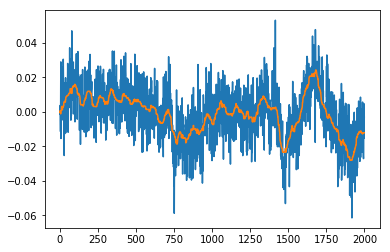

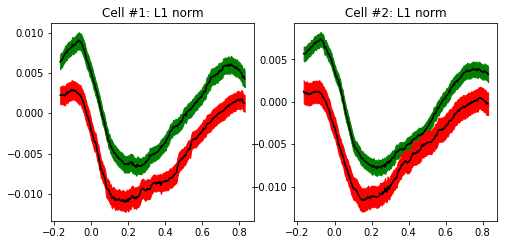

In [104]:


plt.figure(2)
time_range=np.arange(160000,162000)
plt.plot(dff[0,time_range])
plt.plot(subvolt[0,time_range])
# plt.plot(spk[0, time_range]*dff[0,:].max(), '-k')
## mean swim ptterns

stimParam   = frame_stimParams[2,:]+(frame_stimParams[3,:]-1)*4
ntrials     = int(max(frame_stimParams[4,:])-1)

for c in range(2):

    ave_resp_L1  = np.zeros((len(swim_starts),300));
    ave_resp_dff = np.zeros((len(swim_starts),300));

    for i in range(len(swim_starts)):
        ave_resp_L1[i,:]  = subvolt[c,(swim_starts[i]-50):(swim_starts[i]+250)]
#         ave_resp_dff[i,:] = smooth(dff[c,(swim_starts[i]-50):(swim_starts[i]+250)],short_kernel)
    
#     ave_resp_L1 -= ave_resp_L1[:,:30].mean(axis=1)[:,None]
#     ave_resp_dff -= ave_resp_dff[:,:30].mean(axis=1)[:,None]
    
        
    plt.figure(3,figsize=(8,8)) # Swim average during low gain (green) and high gain (red)
    
    sub_ave1_L1 = ave_resp_L1[task_period==1,:].mean(axis=0) ## events during low gain
    sub_err1_L1 = ave_resp_L1[task_period==1,:].std(axis=0)/np.sqrt(ave_resp_L1[task_period==1,:].shape[0])
    sub_ave2_L1 = ave_resp_L1[task_period==2,:].mean(axis=0) ## events during high gain
    sub_err2_L1 = ave_resp_L1[task_period==2,:].std(axis=0)/np.sqrt(ave_resp_L1[task_period==2,:].shape[0])
    plt.subplot(2,2,c+1).fill_between(np.arange(-50,250)/300,sub_ave1_L1-sub_err1_L1, sub_ave1_L1+sub_err1_L1,color='g')
    plt.subplot(2,2,c+1).plot(np.arange(-50,250)/300,sub_ave1_L1,'k')
    plt.subplot(2,2,c+1).fill_between(np.arange(-50,250)/300,sub_ave2_L1-sub_err2_L1, sub_ave2_L1+sub_err2_L1,color='r')
    plt.subplot(2,2,c+1).plot(np.arange(-50,250)/300,sub_ave2_L1,'k')
    plt.title('Cell #'+str(c+1)+': L1 norm')
              
#     sub_ave1_df = ave_resp_dff[task_period==1,:].mean(axis=0) ## events during low gain
#     sub_err1_df = ave_resp_dff[task_period==1,:].std(axis=0)/np.sqrt(ave_resp_dff[task_period==1,:].shape[0])
#     sub_ave2_df = ave_resp_dff[task_period==2,:].mean(axis=0) ## events during high gain
#     sub_err2_df = ave_resp_dff[task_period==2,:].std(axis=0)/np.sqrt(ave_resp_dff[task_period==2,:].shape[0])
#     plt.subplot(2,2,c+3).fill_between(np.arange(-50,250)/300,sub_ave1_df-sub_err1_df, sub_ave1_df+sub_err1_df,color='g')
#     plt.subplot(2,2,c+3).plot(np.arange(-50,250)/300,sub_ave1_df,'k')
#     plt.subplot(2,2,c+3).fill_between(np.arange(-50,250)/300,sub_ave2_df-sub_err2_df, sub_ave2_df+sub_err2_df,color='r')
#     plt.subplot(2,2,c+3).plot(np.arange(-50,250)/300,sub_ave2_df,'k')
#     plt.title('Cell #'+str(c+1)+': Gauss smooth')
    
#     plt.figure(4,figsize=(8,8)) # Swim count-dependent average (k=low gain, b=1-3 bout, g=4-6 bouts, r=7-9 bouts)
    
#     plt.subplot(2,2,c+1).plot(np.arange(-50,250)/300,ave_resp_L1[task_period==1,:].mean(axis=0),'k')
#     plt.subplot(2,2,c+1).plot(np.arange(-50,250)/300,ave_resp_L1[((task_period==2) & (swim_count<=3)),:].mean(axis=0),'b')
#     plt.subplot(2,2,c+1).plot(np.arange(-50,250)/300,ave_resp_L1[((task_period==2) & (swim_count<=6) & (swim_count>=3)),:].mean(axis=0),'g')
#     plt.subplot(2,2,c+1).plot(np.arange(-50,250)/300,ave_resp_L1[((task_period==2) & (swim_count<=9) & (swim_count>=7)),:].mean(axis=0),'r')
#     plt.title('Cell #'+str(c+1)+': L1 norm')
              
#     plt.subplot(2,2,c+3).plot(np.arange(-50,250)/300,ave_resp_dff[task_period==1,:].mean(axis=0),'k')
#     plt.subplot(2,2,c+3).plot(np.arange(-50,250)/300,ave_resp_dff[((task_period==2) & (swim_count<=3)),:].mean(axis=0),'b')
#     plt.subplot(2,2,c+3).plot(np.arange(-50,250)/300,ave_resp_dff[((task_period==2) & (swim_count<=6) & (swim_count>=3)),:].mean(axis=0),'g')
#     plt.subplot(2,2,c+3).plot(np.arange(-50,250)/300,ave_resp_dff[((task_period==2) & (swim_count<=9) & (swim_count>=7)),:].mean(axis=0),'r')
#     plt.title('Cell #'+str(c+1)+': Gauss smooth')

In [101]:
ave_resp_L1.shape

(349, 300)